In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import comb
fontdict = {'family': 'Arial', 'size': 20}
# fontdict = {'family': 'Times New Roman', 'size': 20}
import matplotlib.colors as colors
import matplotlib.transforms as mtransforms

In [9]:
def read_data(model, method, param=None, hist=True):
    if (param):
        if hist:
            data_file = "../data/" + model + "-" + method + "-" + param + "-population_dist.csv"
        else:
            data_file = "../data/" + model + "-" + method + "-" + param + "-single_trajectory_out.csv"
    else:
        if hist:
            data_file = "../data/" + model + "-" + method + "-population_dist.csv"
        else:
            data_file = "../data/" + model + "-" + method + "-single_trajectory_out.csv"
    data = pd.read_csv(data_file, header=0)
    return data

In [10]:
def compute_chi2(p_file, q_file, species, lb, ub):
    hist = np.zeros(int(ub-lb+1))
    
    data_file = q_file
    data = pd.read_csv(data_file, header=0)
    count = data[species].to_numpy()
    weight = data["Weight"].to_numpy()
    for i, x in enumerate(count):
        if x > ub or x < lb:
            continue
        hist[int(x-lb)] += weight[i]
    q = hist / hist.sum()
    
    hist[:] = 0

    data_file = p_file
    data = pd.read_csv(data_file, header=0)
    count = data[species].to_numpy()
    weight = data["Weight"].to_numpy()
    for i, x in enumerate(count):
        if x > ub or x < lb:
            continue
        hist[int(x-lb)] += weight[i]
    p = hist / hist.sum()
    
    x = (p-q)**2
    y = q
    f = np.divide(x, y, out=np.zeros_like(y), where=y!=0)
    chi2 = np.sum(f)

    return chi2

In [11]:
def compute_re(p_file, q_file, species, lb, ub):
    data_file = q_file
    data = pd.read_csv(data_file, header=0)
    qc = data[species].to_numpy()
    
    data_file = p_file
    data = pd.read_csv(data_file, header=0)
    pc = data[species].to_numpy()

    pc = np.where((pc < lb) | (pc > ub), 0, pc)
    qc = np.where((qc < lb) | (qc > ub), 0, qc)
    
    mean_re = np.abs(pc.mean() - qc.mean()) / pc.mean()
    std_re = np.abs(pc.std() - qc.std()) / pc.std()
    result = mean_re if mean_re > std_re else std_re
    return result

In [12]:
def plot_hist_weight(data, weight, c, mtype, name):
    data = data.astype(int)
    ub = data.max()+10
    lb = data.min()-10
    if (ub - lb > 1e5):
        return
    count = np.zeros(int(ub-lb+1))
    for i, x in enumerate(data):
        if x > ub or x < lb:
            continue
        count[int(x-lb)] += weight[i]
    plt.plot(np.arange(lb, ub+1), count/count.sum(), color=c, marker=mtype, ms=10, lw=2, label=name, alpha=0.5)


def plot_model_hist(model, species, method_list, color_list, marker_list, label_list, save=False):
    for method, color, marker, label in zip(method_list, color_list, marker_list, label_list):
        data_file = "../data/" + model + "-" + method + "-population_dist.csv"
        data = pd.read_csv(data_file, header=0)
        count = data[species].to_numpy()
        weight = data["Weight"].to_numpy()
        plot_hist_weight(count, weight, color, marker, label)
    if (save):
        plt.savefig(model + "_histogram.pdf", dpi=600)

def plot_hist_single(model, species, lb, ub, method, color, param=None):
    if (param):
        data_file = "../data/" + model + "-" + method + "-" + param + "-population_dist.csv"
    else:
        data_file = "../data/" + model + "-" + method + "-population_dist.csv"
    data = pd.read_csv(data_file, header=0)
    count = data[species].to_numpy()
    weight = data["Weight"].to_numpy()
    count = np.where((count < lb) | (count > ub), 0, count)
    print(f"model: {model}, method: {method}, mean: {count.mean()}, var: {count.var()}, std: {count.std()}")
    hist = np.zeros(int(ub-lb+1))
    for i, x in enumerate(count):
        if x > ub or x < lb:
            continue
        hist[int(x-lb)] += weight[i]
    plt.plot(np.arange(lb, ub+1), hist/hist.sum(), color=color, marker='o', ms=10, lw=2, label=model+ "-" + method, alpha=0.5)


def plot_traj_single(model, species, method, color, param=None):
    if (param):
        data_file = "../data/" + model + "-" + method + "-" + param + "-single_trajectory_out.csv"
    else:
        data_file = "../data/" + model + "-" + method + "-single_trajectory_out.csv"
    data = pd.read_csv(data_file, header=0)
    t = data["Time"].to_numpy()
    p = data[species].to_numpy()
    plt.plot(t, p, '.', color=color, ms=1, label=model + ":" + method, alpha=0.5)

In [13]:
def plot_birth_death_cme():
    p = []
    k1, k2 = 0.1, 1
    p.append(1)
    p.append(k2/k1*p[0])
    for i in range(1, 22):
        x = 1/(k1*(i+1))*(k1*i*p[i]+k2*p[i]-k2*p[i-1])
        p.append(x)
        
    p = np.array(p)    
    plt.plot(np.arange(23), p/p.sum(), 'k-', lw=1, label='CME')

def plot_isomerization_cme():
    p = []
    k1, k2 = 10, 10
    N = 200
    p.append(1)
    p.append(k2*N/k1*p[0])
    for i in range(1, 149):
        x = 1/(k1*(i+1))*(k1*i*p[i]+k2*(N-i)*p[i]-k2*(N-i+1)*p[i-1])
        p.append(x)
        
    p = np.array(p)    
    ix = np.arange(60, 140)
    plt.plot(ix, p[ix]/p.sum(), color='black', lw=1, label='CME')

def plot_sequencial_cme():
    seq_cme = pd.read_csv("sequence_CME.csv", header=0)
    x = np.arange(1, 100)
    y = seq_cme.to_numpy()
    plt.plot(x, y[x-1], color='black', lw=1, label='CME')

def plot_schlogl_cme():
    p = []
    c1 = 3e-7
    c2 = 1e-4
    c3 = 1e-3
    c4 = 3.5
    n1 = 1e5
    n2 = 197000
    N = 800
    p.append(1)
    n = 0
    a = c1*n1/2*(n-1)*(n-2)+c3*n2
    b = 1/6*(n+1)*n*(n-1)*c2 + c4*(n+1)
    c = c1*n1/2*n*(n-1)+1/6*n*(n-1)*(n-2)*c2+c3*n2+c4*n

    x = c/b*p[0]

    p.append(x)
    for n in range(1, N):
        a = c1*n1/2*(n-1)*(n-2)+c3*n2
        b = 1/6*(n+1)*n*(n-1)*c2 + c4*(n+1)
        c = c1*n1/2*n*(n-1)+1/6*n*(n-1)*(n-2)*c2+c3*n2+c4*n
        x = 1/b*(c*p[n]-a*p[n-1])
        p.append(x)
        
    p = np.array(p)    
    ix = np.arange(0, N)

    plt.plot(ix, p[ix]/p.sum(), color='black', lw=1, label='CME')


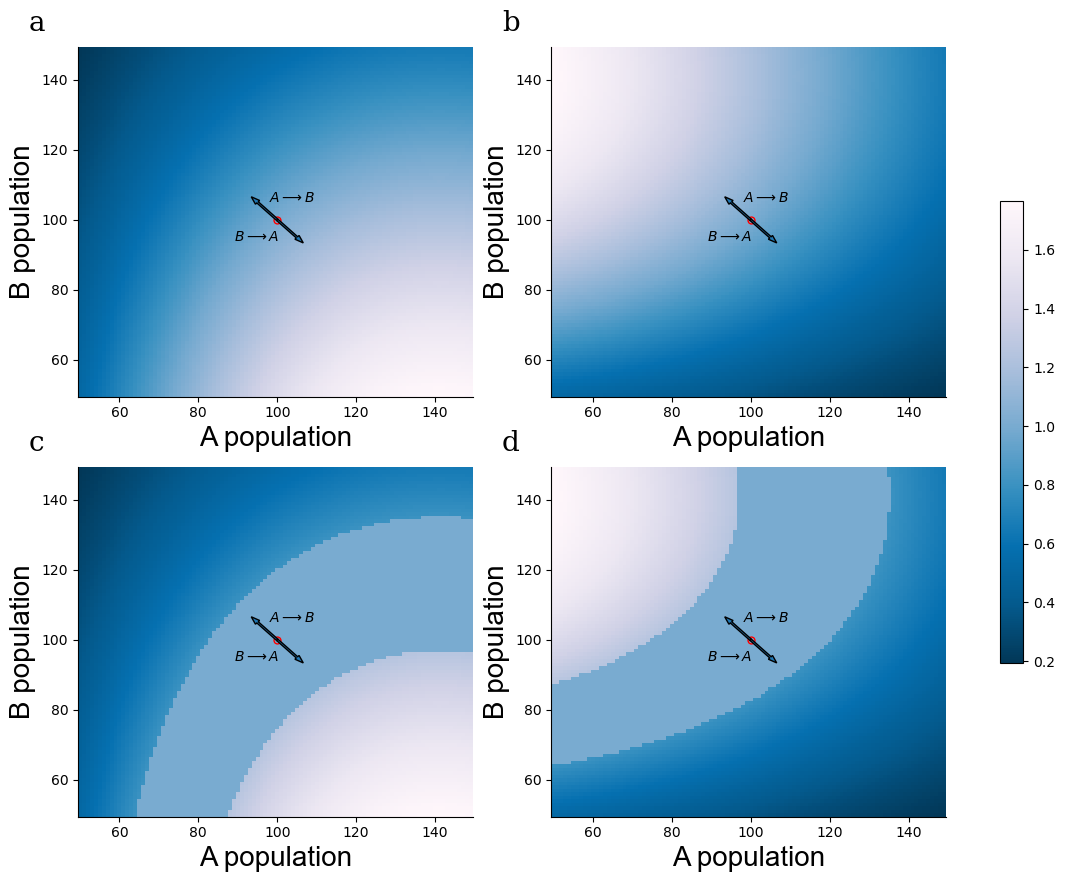

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# weight bound
bw = 0.8

# number
na = 100
nb = 100
# rate
ka = 1
kb = 1
# stochiometric
va = 2
vb = 2
# propensity
pa0 = ka * comb(na, va) 
pb0 = kb * comb(nb, vb)
ua0 = pa0 + pb0

a = np.arange(50, 150, 1)
b = np.arange(50, 150, 1)
aa, bb = np.meshgrid(a, b)

a0 = ka * comb(aa, va) +  kb * comb(bb, vb)
dt = 1/ua0
w = ka * comb(aa, va) / pa0 * np.exp(- (a0 - ua0) * dt)
 
ax = plt.subplot(221)

pcm = ax.pcolormesh(aa, bb, w, cmap='PuBu_r', shading='nearest', linewidth=0, rasterized=True)
ax.scatter(100, 100, 1, c='red', linewidths=5)
arrow_size = 5
ax.arrow(100, 100, -arrow_size, arrow_size, width=0.5)
ax.arrow(100, 100, arrow_size, -arrow_size, width=0.5)
plt.text(98, 105, r"$A \longrightarrow B$")
plt.text(89, 94, r"$B \longrightarrow A$")
plt.xlabel("A population", fontdict=fontdict)
plt.ylabel("B population", fontdict=fontdict)

w = kb * comb(bb, vb) / pb0 * np.exp(- (a0 - ua0) * dt)

ax = plt.subplot(222)

pcm = ax.pcolormesh(aa, bb, w, cmap='PuBu_r', shading='nearest', linewidth=0, rasterized=True)
ax.scatter(100, 100, 1, c='red', linewidths=5)
arrow_size = 5
ax.arrow(100, 100, -arrow_size, arrow_size, width=0.5)
ax.arrow(100, 100, arrow_size, -arrow_size, width=0.5)
plt.text(98, 105, r"$A \longrightarrow B$")
plt.text(89, 94, r"$B \longrightarrow A$")
plt.xlabel("A population", fontdict=fontdict)
plt.ylabel("B population", fontdict=fontdict)


va = 2
vb = 2
# propensity
pa0 = ka * comb(na, va) 
pb0 = kb * comb(nb, vb)
ua0 = pa0 + pb0

a = np.arange(50, 150, 1)
b = np.arange(50, 150, 1)
aa, bb = np.meshgrid(a, b)

a0 = ka * comb(aa, va) +  kb * comb(bb, vb)
dt = 1/ua0
w = ka * comb(aa, va) / pa0 * np.exp(- (a0 - ua0) * dt)
w = np.where((w > bw) & (w < 1/bw), 1, w)

ax = plt.subplot(223)

pcm = ax.pcolormesh(aa, bb, w, cmap='PuBu_r', shading='nearest', linewidth=0, rasterized=True)
ax.scatter(100, 100, 1, c='red', linewidths=5)
arrow_size = 5
ax.arrow(100, 100, -arrow_size, arrow_size, width=0.5)
ax.arrow(100, 100, arrow_size, -arrow_size, width=0.5)
plt.text(98, 105, r"$A \longrightarrow B$")
plt.text(89, 94, r"$B \longrightarrow A$")
plt.xlabel("A population", fontdict=fontdict)
plt.ylabel("B population", fontdict=fontdict)

w = kb * comb(bb, vb) / pb0 * np.exp(- (a0 - ua0) * dt)
w = np.where((w > bw) & (w < 1/bw), 1, w)

ax = plt.subplot(224)

pcm = ax.pcolormesh(aa, bb, w, cmap='PuBu_r', shading='nearest', linewidth=0, rasterized=True)
# plt.imshow(w)
ax.scatter(100, 100, 1, c='red', linewidths=5)
arrow_size = 5
ax.arrow(100, 100, -arrow_size, arrow_size, width=0.5)
ax.arrow(100, 100, arrow_size, -arrow_size, width=0.5)
plt.text(98, 105, r"$A \longrightarrow B$")
plt.text(89, 94, r"$B \longrightarrow A$")
plt.xlabel("A population", fontdict=fontdict)
plt.ylabel("B population", fontdict=fontdict)

fig.colorbar(pcm, ax=axes[:, :], shrink=0.6)

figure_labels = ['a', 'b', 'c', 'd']
for i in range(2):
    for j in range(2):
        idx = i * 2 + j
        plt.subplot(2, 2, idx+1)
        axes[i][j].spines['right'].set_visible(False)
        axes[i][j].spines['top'].set_visible(False)
        trans = mtransforms.ScaledTranslation(-50/72, 7/72, fig.dpi_scale_trans)
        axes[i, j].text(0.05, 1.0, figure_labels[idx], transform=axes[i, j].transAxes + trans,
                    fontsize=20, verticalalignment='bottom', fontfamily='serif',
                    bbox=dict(facecolor='1.0', edgecolor='none', pad=3.0))


#plt.savefig("mean_field_state_weight_isomerization_model.pdf", dpi=300)

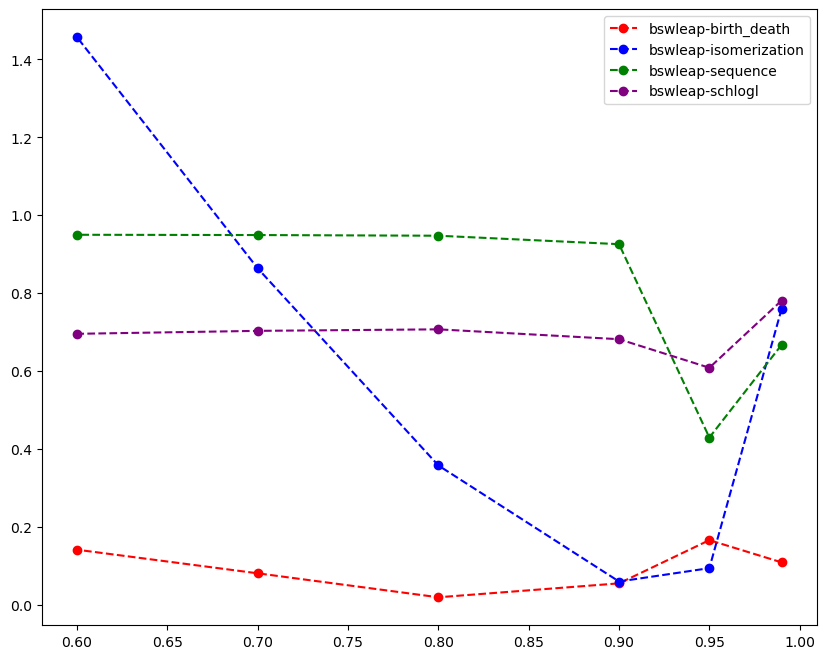

In [72]:
plt.figure(figsize=(10, 8))

models = ["birth_death", "isomerization", "sequence", "schlogl"]
species = ["A", "S2", "S3", "S1"]
#methods = ["bswleap", "blwleap"]
methods = ["bswleap"]
#methods = ["blwleap"]
bw = ['0.990000', '0.950000', '0.900000', '0.800000', '0.700000', '0.600000']
x = [0.99, 0.95, 0.9, 0.8, 0.7, 0.6]

model = models[0]
p_file = "../data/" + model + "-" + "dm" + "-population_dist.csv"
q_file  = "../data/" + model + "-" + "nbwleap-population_dist.csv"
y = compute_chi2(p_file, q_file, species[0], 0, 20)
#plt.hlines(y, 0.6, 0.95, label="nbw" + "-" + model, color='r')
for method in methods:
    cs = []
    for b in range(len(bw)):
        q_file  = "../data/" + model + "-" + method + "-bw_" + bw[b] + "-population_dist.csv"
        cs.append(compute_re(p_file, q_file, species[0], 0, 40))
    plt.plot(x, cs, 'o--', color='r', label=method + "-" + model)
   
model = models[1]
p_file = "../data/" + model + "-" + "dm" + "-population_dist.csv"
q_file  = "../data/" + model + "-" + "nbwleap-population_dist.csv"
y = compute_chi2(p_file, q_file, species[1], 80, 120)
#plt.hlines(y, 0.6, 0.95, label="nbw" + "-" + model, color='b')
for method in methods:
    cs = []
    for b in range(len(bw)):
        q_file  = "../data/" + model + "-" + method + "-bw_" + bw[b] + "-population_dist.csv"
        cs.append(compute_re(p_file, q_file, species[1], 50, 150))
    plt.plot(x, cs, 'o--', color='b', label=method + "-" + model)
   
model = models[2]
p_file = "../data/" + model + "-" + "dm" + "-population_dist.csv"
q_file  = "../data/" + model + "-" + "nbwleap-population_dist.csv"
y = compute_chi2(p_file, q_file, species[2], 20, 80)
#plt.hlines(y, 0.6, 0.95, label="nbw" + "-" + model, color='g')
for method in methods:
    cs = []
    for b in range(len(bw)):
        q_file  = "../data/" + model + "-" + method + "-bw_" + bw[b] + "-population_dist.csv"
        cs.append(compute_re(p_file, q_file, species[2], 0, 100))
    plt.plot(x, cs, 'o--', color='g', label=method + "-" + model)

model = models[3]
p_file = "../data/" + model + "-" + "dm" + "-population_dist.csv"
q_file  = "../data/" + model + "-" + "nbwleap-population_dist.csv"
y = compute_chi2(p_file, q_file, species[3], 0, 200)
#plt.hlines(y, 0.6, 0.95, label="nbw" + "-" + model, color='purple')
for method in methods:
    cs = []
    for b in range(len(bw)):
        q_file  = "../data/" + model + "-" + method + "-bw_" + bw[b] + "-population_dist.csv"
        cs.append(compute_re(p_file, q_file, species[3], 0, 200))
    plt.plot(x, cs, 'o--', color='purple', label=method + "-" + model)
    
plt.legend()

# weight bounding also acting as a selection mechanism
# so for strong selection, relative errors may still increase

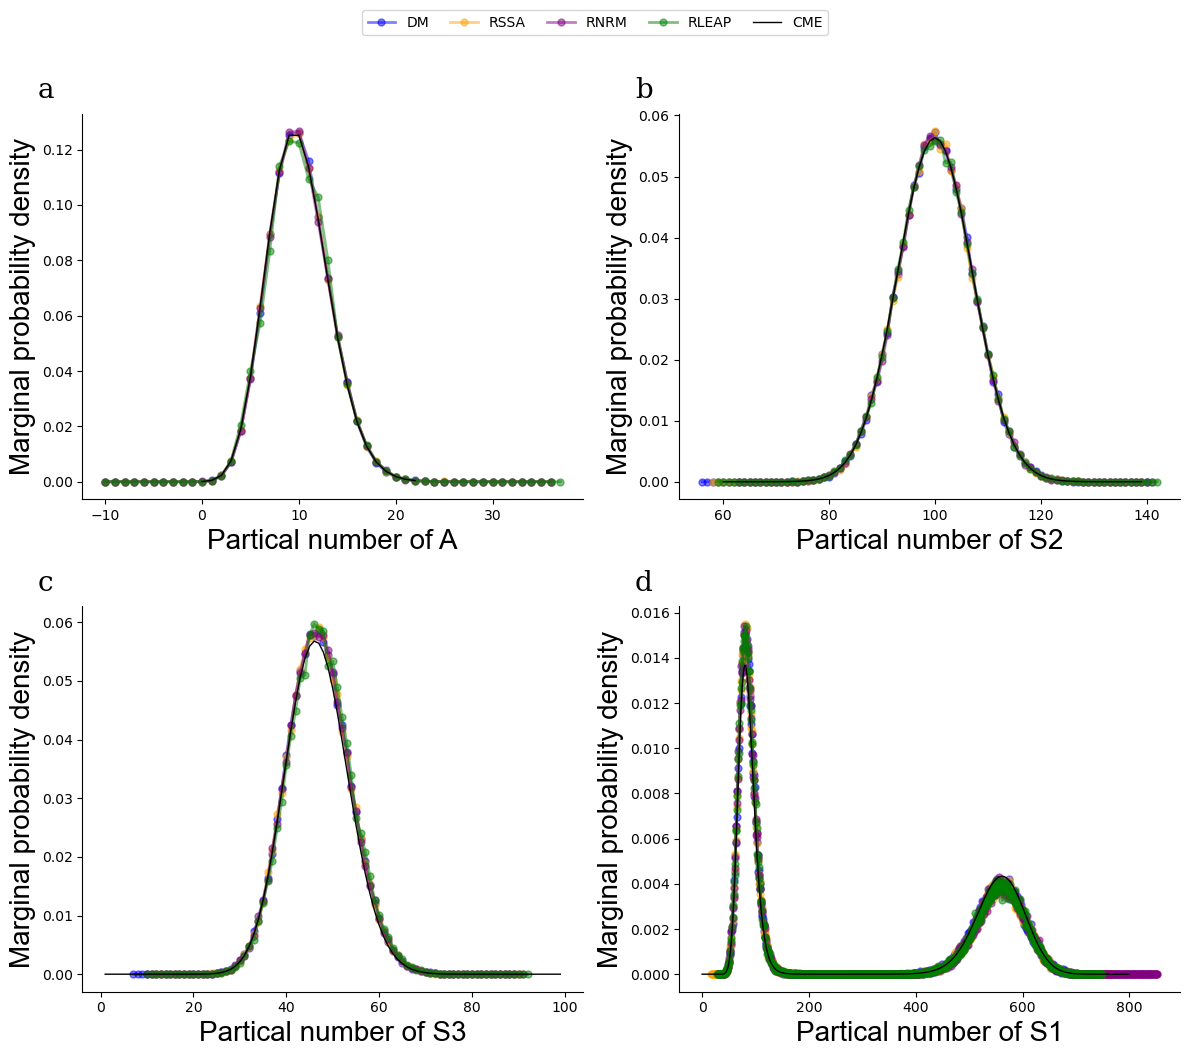

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))


method_list = ["dm", "rssa", "rnrm", "rleap"]
color_list = ["blue", "orange", "purple", "green"]
# color_list = ["C" + str(i) for i in range(10)]
marker_list = ["." for i in range(10)]
label_list = ["DM", "RSSA", "RNRM", "RLEAP"]

models = ["birth_death", "isomerization", "sequence", "schlogl"]
figure_labels = ['a', 'b', 'c', 'd']
figure_titles = ["Birth-death model", "Isomerization model", "Sequential model", "Schlogl model"]
species = ["A", "S2", "S3", "S1"]
cme_funcs = [plot_birth_death_cme, plot_isomerization_cme, plot_sequencial_cme, plot_schlogl_cme]
for i in range(2):
    for j in range(2):
        idx = i * 2 + j
        ax = plt.subplot(2, 2, idx+1)
        plot_model_hist(models[idx], species[idx], method_list, color_list, marker_list, label_list, save=False)
        cme_funcs[idx]()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.xlabel("Partical number of " + species[idx], fontdict=fontdict)
        plt.ylabel("Marginal probability density", fontdict=fontdict)
        # plt.legend()
        # plt.title(figure_titles[idx], fontdict=fontdict)
        trans = mtransforms.ScaledTranslation(-50/72, 7/72, fig.dpi_scale_trans)
        ax.text(0.05, 1.0, figure_labels[idx], transform=axes[i, j].transAxes + trans,
                    fontsize=20, verticalalignment='bottom', fontfamily='serif',
                    bbox=dict(facecolor='1.0', edgecolor='none', pad=3.0))

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower left", bbox_to_anchor=(0.3, 1.02, 0.4, 0.2), mode="expand", ncol=5)
plt.tight_layout()
#plt.savefig("marginal_prob_density_4_models_exact.pdf", dpi=300, bbox_inches="tight")


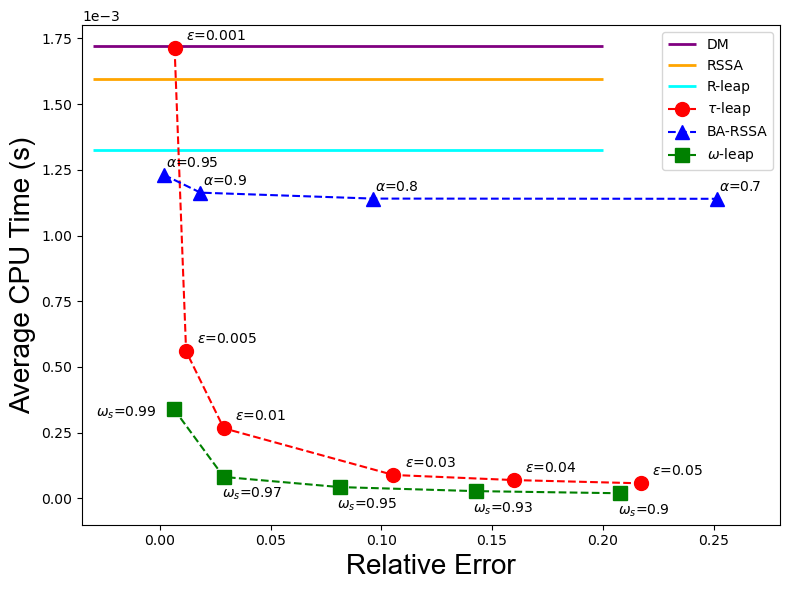

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

model = "dimer"
species = "S1"

tau = [0.001000, 0.005000, 0.010000, 0.030000, 0.040000, 0.050000]

# ba = [0.950000, 0.900000, 0.800000, 0.700000, 0.600000]
ba = [0.950000, 0.900000, 0.800000, 0.700000]

bw = [0.990000, 0.970000, 0.950000, 0.930000, 0.900000]

tau_cpu = [171.27, 55.95, 26.68, 8.92, 6.98, 5.75]

# ba_cpu = [124.56, 117.78, 115.53, 115.36, 115.61]
ba_cpu = [123.06, 116.3, 114.04, 113.96]

# bw_cpu = [33.85, 8.02, 4.22, 2.87, 1.89, 1.17, 1.96, 2.19]
bw_cpu = [33.97, 8.17, 4.32, 2.78, 1.97]

dm_cpu = 172.0 / 1e5
ax.hlines(dm_cpu, -0.03, 0.2, label="DM", linewidth=2, colors="purple")
rssa_cpu = 159.47 / 1e5
ax.hlines(rssa_cpu, -0.03, 0.2, label="RSSA", linewidth=2, colors="orange")
rleap_cpu = 132.34 / 1e5
ax.hlines(rleap_cpu, -0.03, 0.2, label="R-leap", linewidth=2, colors="cyan")

p_file = "../data/" + model + "-dm-population_dist.csv"
cs = []
param_str = [f"{i:.6f}" for i in tau]
for i in param_str:
    q_file = "../data/" + model + "-tleap-tau_" + i + "-population_dist.csv"
    cs.append(compute_re(p_file, q_file, species, 500, 800))
    #cs.append(compute_chi2(p_file, q_file, species, 500, 800))
y = np.array(tau_cpu) / 1e5
ax.plot(cs, y, "o--", color="red", markersize=10, label=r"$\tau$-leap")
tx = 0.005
ty = 0.00003
for i in range(len(cs)):
    ax.text(cs[i]+tx, y[i]+ty, fr"$\epsilon$={tau[i]}")

cs = []
param_str = [f"{i:.6f}" for i in ba]
for i in param_str:
    q_file = "../data/" + model + "-barssa-ba_" + i + "-population_dist.csv"
    cs.append(compute_re(p_file, q_file, species, 500, 800))
    #cs.append(compute_chi2(p_file, q_file, species, 500, 800))

y = np.array(ba_cpu) / 1e5
ax.plot(cs, y, "^--", color="blue", markersize=10, label="BA-RSSA")
tx = 0.001
ty = 0.00003
for i in range(len(cs)):
    ax.text(cs[i]+tx, y[i]+ty, fr"$\alpha$={ba[i]}")

cs = []
param_str = [f"{i:.6f}" for i in bw]
for i in param_str:
    q_file = "../data/" + model + "-adaptleap-bw_" + i + "-population_dist.csv"
    cs.append(compute_re(p_file, q_file, species, 500, 800))
    #cs.append(compute_chi2(p_file, q_file, species, 500, 800))

y = np.array(bw_cpu) / 1e5
ax.plot(cs, y, "s--", color="green", markersize=10, label=r"$\omega$-leap")
ax.text(cs[0]-0.035, y[0]-0.00003, fr"$\omega_s$={bw[0]}")
ax.text(cs[1]-0.001, y[1]-0.00008, fr"$\omega_s$={bw[1]}")
ax.text(cs[2]-0.001, y[2]-0.00008, fr"$\omega_s$={bw[2]}")
ax.text(cs[3]-0.001, y[3]-0.00008, fr"$\omega_s$={bw[3]}")
ax.text(cs[4]-0.001, y[4]-0.00008, fr"$\omega_s$={bw[4]}")


plt.ylabel("Average CPU Time (s)", fontdict=fontdict)
plt.xlabel("Relative Error", fontdict=fontdict)
plt.ticklabel_format(style='sci', scilimits=(-1, 2), axis='y')
plt.xlim((-0.035, 0.28))
plt.ylim((-0.0001, 0.0018))
plt.legend()
plt.tight_layout()

#plt.savefig("non-stiff_dimer_acc_eff.pdf", dpi=300)

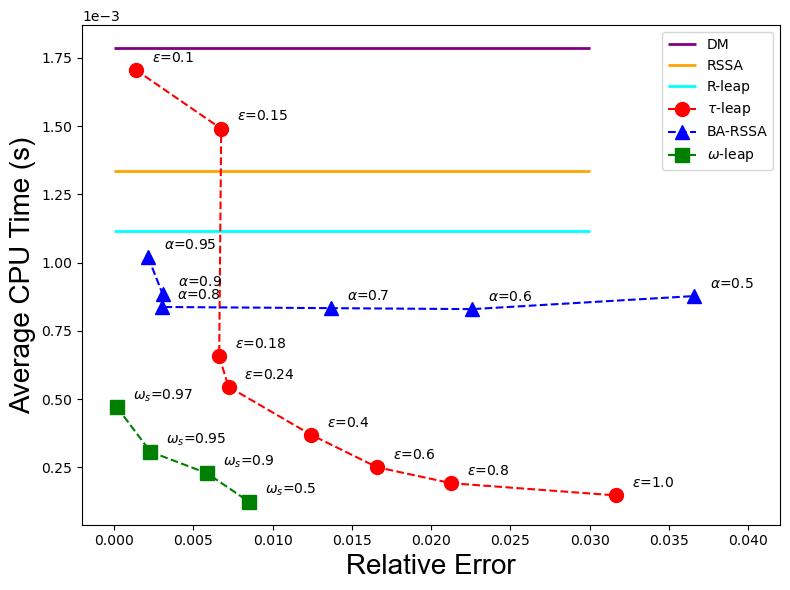

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

model = "schlogl"
species = "S1"

tau = [
    (0.1, 170.59),
    (0.15, 149.05),
    (0.18, 65.63),
    (0.24, 54.49),
    (0.4, 36.87),
    (0.6, 25.05),
    (0.8, 19.18), 
    (1.0, 14.72)
]


ba = [
    (0.95, 101.91),
    (0.9, 88.56), 
    (0.8, 83.74),
    (0.7, 83.31),
    (0.6, 82.95),
    (0.5, 87.74)
]

bw = [
    (0.97, 46.98),
    (0.95, 30.71),
    (0.9, 22.82),
    (0.5, 12.30),
]


dm_cpu = 178.64 / 1e5
ax.hlines(dm_cpu, 0, 0.03, label="DM", linewidth=2, colors="purple")
rssa_cpu = 133.59 / 1e5
ax.hlines(rssa_cpu, 0, 0.03, label="RSSA", linewidth=2, colors="orange")
rleap_cpu = 111.41 / 1e5
ax.hlines(rleap_cpu, 0, 0.03, label="R-leap", linewidth=2, colors="cyan")

p_file = "../data/" + model + "-dm-population_dist.csv"
cs = []
ss = []
for x in tau:
    param, cpu = x
    param_str = f"{param:.6f}"
    q_file = "../data/" + model + "-tleap-tau_" + param_str + "-population_dist.csv"
    #cs.append(compute_chi2(p_file, q_file, species, 0, 800))
    cs.append(compute_re(p_file, q_file, species, 0, 200))
    #cs.append(compute_re(p_file, q_file, species, 400, 700))
    ss.append(cpu)
    
y = np.array(ss) / 1e5
ax.plot(cs, y, "o--", color="red", markersize=10, label=r"$\tau$-leap")
tx = 0.001
ty = 0.00003
for i in range(len(cs)):
    ax.text(cs[i]+tx, y[i]+ty, fr"$\epsilon$={tau[i][0]}")

cs = []
ss = []
param_str = [f"{i:.6f}" for i, j in ba]
for x in ba:
    param, cpu = x
    param_str = f"{param:.6f}"
    q_file = "../data/" + model + "-barssa-ba_" + param_str + "-population_dist.csv"
    #cs.append(compute_chi2(p_file, q_file, species, 0, 800))
    cs.append(compute_re(p_file, q_file, species, 0, 200))
    #cs.append(compute_re(p_file, q_file, species, 400, 700))
    ss.append(cpu)

y = np.array(ss) / 1e5
ax.plot(cs, y, "^--", color="blue", markersize=10, label="BA-RSSA")
tx = 0.001
ty = 0.00003
for i in range(len(cs)):
    ax.text(cs[i]+tx, y[i]+ty, fr"$\alpha$={ba[i][0]}")

cs = []
ss = []
param_str = [f"{i:.6f}" for i, j in bw]
for x in bw:
    param, cpu = x
    param_str = f"{param:.6f}"
    q_file = "../data/" + model + "-adaptleap-bw_" + param_str + "-population_dist.csv"
    #cs.append(compute_chi2(p_file, q_file, species, 0, 800))
    cs.append(compute_re(p_file, q_file, species, 0, 200))
    #cs.append(compute_re(p_file, q_file, species, 400, 700))
    ss.append(cpu)

y = np.array(ss) / 1e5
ax.plot(cs, y, "s--", color="green", markersize=10, label=r"$\omega$-leap")
tx = 0.001
ty = 0.00003
for i in range(len(cs)):
    ax.text(cs[i]+tx, y[i]+ty, fr"$\omega_s$={bw[i][0]}")


plt.ylabel("Average CPU Time (s)", fontdict=fontdict)
plt.xlabel("Relative Error", fontdict=fontdict)
plt.ticklabel_format(style='sci', scilimits=(-1, 2), axis='y')
plt.xlim((-0.002, 0.042))
#plt.ylim((-0.0001, 0.0020))
plt.legend()
plt.tight_layout()

#plt.savefig("schlogl_acc_eff.pdf", dpi=300)

/tmp/ipykernel_4056/2591961598.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


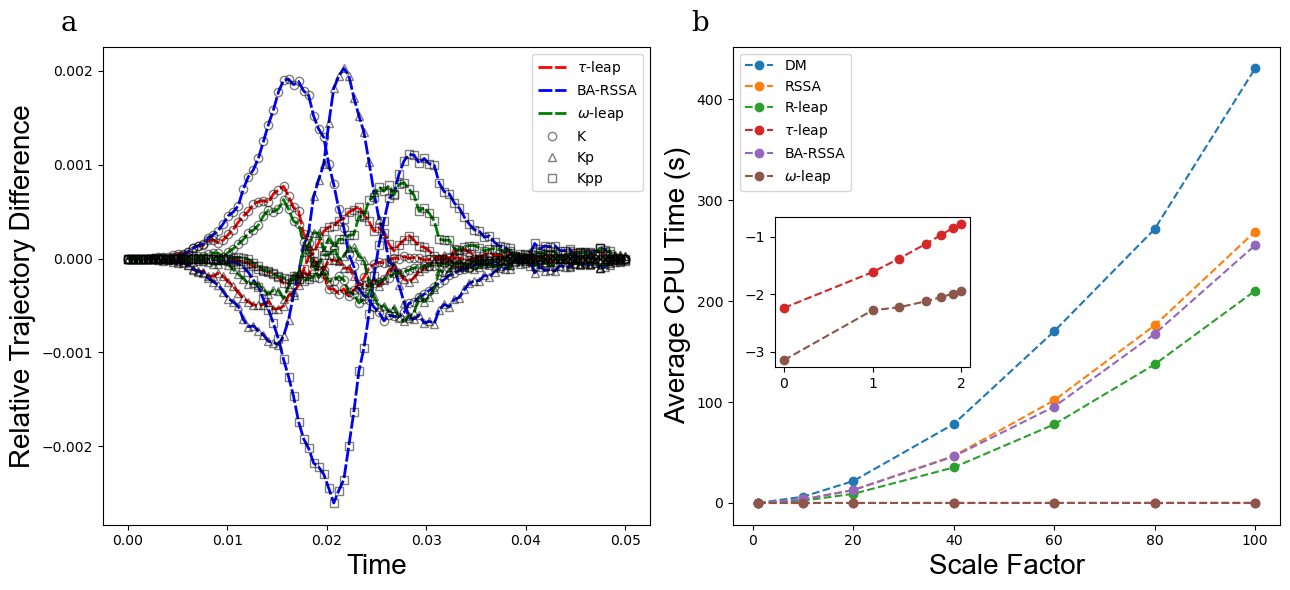

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6))

ax = plt.subplot(121)

methods = ["tleap", "barssa", "adaptleap"]
method_labels = [r"$\tau$-leap", "BA-RSSA", r"$\omega$-leap"]
params = ['tau_0.010000', 'ba_0.900000', 'bw_0.990000']
method_colors = ['r', 'b', 'g']
species = ["K", "Kp", "Kpp"]
species_markers = ["o", "^", "s"]
init_p = 20000000

x = np.linspace(0, 0.05, 100)
ddata = read_data("MAPKx10", "dm", hist=False)
td = ddata["Time"]
for i in range(len(methods)):
    data = read_data("MAPKx10", methods[i], params[i], hist=False)
    t = data["Time"]
    for j in range(len(species)):
        yd = np.interp(x, td, ddata[species[j]])
        y = np.interp(x, t, data[species[j]])
        # plot lines
        if species[j] == "K":
            plt.plot(x, (y-yd)/init_p, linestyle=(0, (5, 1)), lw=2, color=method_colors[i], label=method_labels[i])
        else:
            plt.plot(x, (y-yd)/init_p, linestyle=(0, (5, 1)), lw=2, color=method_colors[i])
            
for i in range(len(methods)):
    data = read_data("MAPKx10", methods[i], params[i], hist=False)
    t = data["Time"]
    for j in range(len(species)):
        yd = np.interp(x, td, ddata[species[j]])
        y = np.interp(x, t, data[species[j]])
        # plot markers
        if methods[i] == "tleap":
            plt.plot(x, (y-yd)/init_p, lw=0, color='k', marker=species_markers[j], markerfacecolor='none', alpha=0.5, label=species[j])
        else:
            plt.plot(x, (y-yd)/init_p, lw=0, color='k', marker=species_markers[j], markerfacecolor='none', alpha=0.5)

plt.legend()

plt.xlabel("Time", fontdict=fontdict)
plt.ylabel("Relative Trajectory Difference", fontdict=fontdict)

ax = plt.subplot(122)

scale_factors = [1, 10, 20, 40, 60, 80, 100]
dm_cpu = [0.012250, 6.225195, 21.713260, 78.223508, 170.181757, 271.546197, 430.688832]
rssa_cpu = [0.008557, 3.625881, 12.810945, 46.654022, 101.725502, 176.064789, 269.053503]
rleap_cpu = [0.014521, 2.268642, 9.057508, 35.246589, 77.888066, 137.346839,  210.389355]
tleap_cpu = [0.005784, 0.024129, 0.041418, 0.074816, 0.107458, 0.139448, 0.166126]
barssa_cpu = [0.004907, 3.569213, 12.727557, 46.115756, 95.421139, 167.619719, 255.497895]
adaptleap_cpu = [0.002925, 0.011631, 0.012296, 0.011385, 0.010849, 0.012720, 0.014103]

plt.plot(scale_factors, dm_cpu, 'o--', label="DM")
plt.plot(scale_factors, rssa_cpu, 'o--', label="RSSA")
plt.plot(scale_factors, rleap_cpu, 'o--', label="R-leap")
plt.plot(scale_factors, tleap_cpu, 'o--', label=r"$\tau$-leap")
plt.plot(scale_factors, barssa_cpu, 'o--', label="BA-RSSA")
plt.plot(scale_factors, adaptleap_cpu, 'o--', label=r"$\omega$-leap")


plt.xlabel("Scale Factor", fontdict=fontdict)
plt.ylabel("Average CPU Time (s)", fontdict=fontdict)

plt.legend()

ax = plt.subplot(121)
trans = mtransforms.ScaledTranslation(-50/72, 7/72, fig.dpi_scale_trans)
ax.text(0.05, 1.0, 'a', transform=ax.transAxes + trans,
                    fontsize=20, verticalalignment='bottom', fontfamily='serif',
                    bbox=dict(facecolor='1.0', edgecolor='none', pad=3.0))

ax = plt.subplot(122)
trans = mtransforms.ScaledTranslation(-50/72, 7/72, fig.dpi_scale_trans)
ax.text(0.05, 1.0, 'b', transform=ax.transAxes + trans,
                    fontsize=20, verticalalignment='bottom', fontfamily='serif',
                    bbox=dict(facecolor='1.0', edgecolor='none', pad=3.0))


ax1 = fig.add_axes([0.6, 0.38, 0.15, 0.25])
ax1.plot(np.log10(scale_factors), np.log10(tleap_cpu), 'o--', color="tab:red")
ax1.plot(np.log10(scale_factors), np.log10(scaleleap_cpu), 'o--', color="tab:brown")

plt.tight_layout()


plt.savefig("scale_MAPK.pdf", dpi=300, bbox_inches='tight')